You need to download your PG&E data. This is the current instructions:
https://www.pge.com/pge_global/common/pdfs/save-energy-money/analyze-your-usage/energy-data-hub/Download-My-Data-User-Guide.pdf

Be sure to use the option "Export usage for a range of days" so that you have hour-by-hour usage. There is a one-year limit so, if you want a longer period, you will have to repeat the process and concatenate the files. I have my own usage data here.

This code is experimental and provided as is. Comments can be emailed to tony.bruguier@gmail.com

In [1]:
import csv
from datetime import (date, datetime, time)
from dateutil import relativedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

In [2]:
input_filename = 'pge_usage.tsv'  # Point to your file that you donwloaded.

data = []
with open(input_filename, newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    for row in csvreader:
        if len(row) >= 7 and row[0] == 'Electric usage':
            d = date.fromisoformat(row[1])
            t = time.fromisoformat(row[2])
            u = float(row[4])
            data.append((d, t, u,))
            
# We do not want partial months, as they mess up the analysis, so we trim the
# data to remove the first and last months of the series.
_min_year = min(x[0].year for x in data)
_min_month = min(x[0].month for x in data if x[0].year == _min_year)

_max_year = max(x[0].year for x in data)
_max_month = max(x[0].month for x in data if x[0].year == _max_year)

data = [x for x in data if (x[0].year > _min_year or x[0].month > _min_month)
                       and (x[0].year < _max_year or x[0].month < _max_month)]

# Sort the data, just in case it wasn't
data = sorted(data, key=lambda x: datetime.combine(x[0], x[1]))

first_date = data[0][0]
last_date = data[-1][0]


Now, we have parsed the data. Let's do some analysis of the usage.

Text(0.5, 1.0, 'Usage in kWh for a given month')

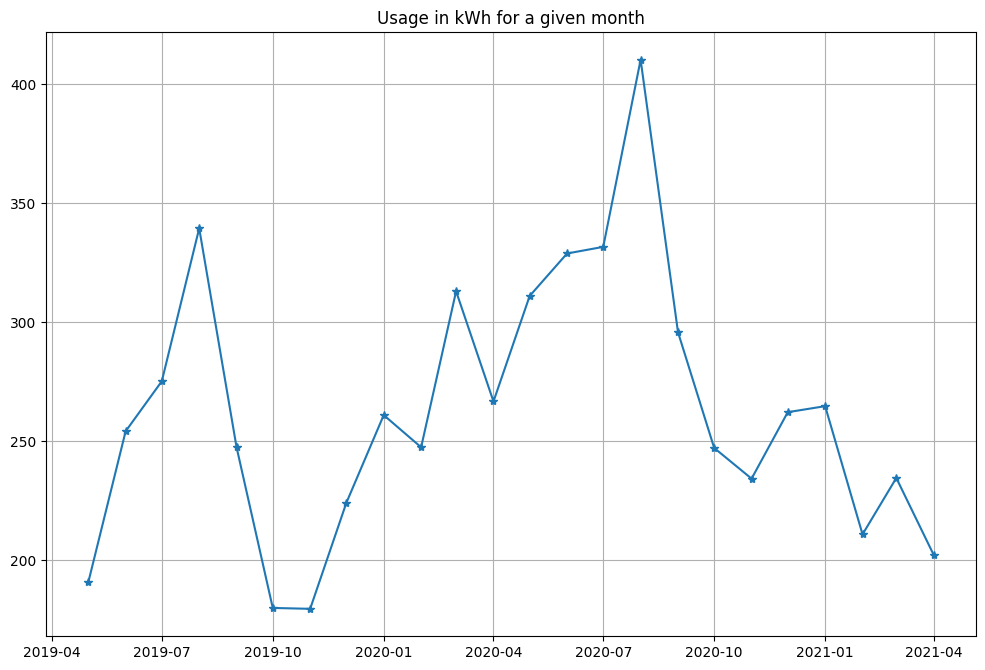

In [3]:
# Print usage by month.
xs = []
ys = []
for year in range(first_date.year, last_date.year + 1):
    for month in range(first_date.month if year == first_date.year else 1,
                       last_date.month + 1 if year == last_date.year else 12 + 1):
        xs.append(date(year, month, 1))
        ys.append(sum(x[2] for x in data if x[0].year == year and x[0].month == month))

fig = plt.figure(figsize=(12,8), dpi=100)
plt.plot_date(xs, ys, '-*')
plt.grid()
plt.title('Usage in kWh for a given month')

Text(0.5, 1.0, 'Usage in kWh for a given day, but normalized to a month')

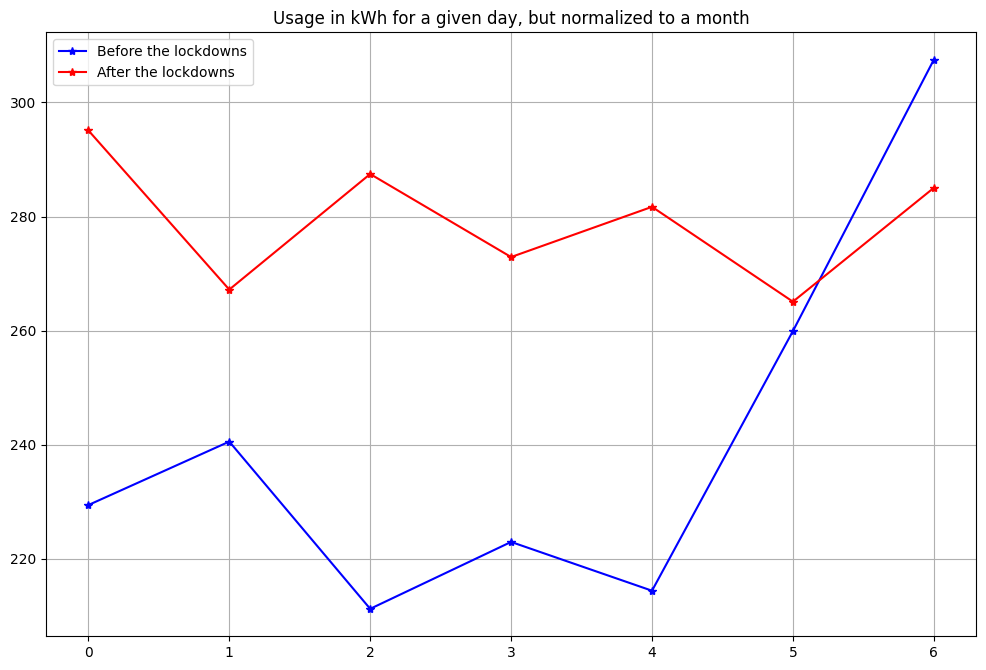

In [4]:
# Plot by day of the week, before and after the lockdowns
xs = []
ys_before = []
ys_after = []

def _average_per_day(x):
    return sum(x) / len(x) * 24.0 * 365.0 / 12.0

for day_of_week in range(7):  # 0=Monday, 6=Sunday
    xs.append(day_of_week)
    ys_before.append(_average_per_day([x[2] for x in data if x[0].weekday() == day_of_week and x[0] < date(2020, 3, 17)]))
    ys_after.append(_average_per_day([x[2] for x in data if x[0].weekday() == day_of_week and x[0] >= date(2020, 3, 17)]))

fig = plt.figure(figsize=(12,8), dpi=100)
plt.plot(xs, ys_before, '-*b')
plt.plot(xs, ys_after, '-*r')
plt.grid()

plt.legend(['Before the lockdowns', 'After the lockdowns'])
plt.title('Usage in kWh for a given day, but normalized to a month')